# Plot the waveforms, CWT power spectra, and cross-correlations of a high-Q glider recorded on a pair of stations

In [15]:
# Imports
from os.path import join
from matplotlib.pyplot import subplots
from matplotlib.ticker import MultipleLocator
from obspy.signal.cross_correlation import correlate
from pandas import Timestamp
from scipy.signal import correlate
from numpy import linspace, geomspace
from numpy.linalg import norm

from utils_basic import GEO_COMPONENTS as components, ROOTDIR_GEO as rootdir
from utils_basic import get_geophone_locs, time2filename
from utils_preproc import read_and_process_windowed_geo_waveforms
from utils_wavelet import get_scales_and_freqs, get_stream_cwt
from utils_plot import plot_waveforms_cwt_and_xcorr, save_figure

In [16]:
# Inputs
## Data
station1= "A05"
station2 = "A06"
starttime = "2020-01-13T20:01:01.5Z"
duration = 10.0

## Preprocessing
min_freq_filt = 40.0
max_freq_filt = 75.0

deci_factor = 2 # Decimation factor

## Wavelet transform
wavelet = "cmor"
bandwidth = 20.0
center_freq = 2.0
min_scales = 5
max_sacale = 50
num_scales = 128

## Plotting
wf_lim = (-50.0, 50.0)
freq_lim = (40.0, 75.0)

dbmin = 0.0
dbmax = 40.0

linewidth_wf = 0.2
linewidth_cc = 2
linewdith_max = 2

In [17]:
# Get the distance between the stations
sta_df = get_geophone_locs()

east1 = sta_df.loc[sta_df["name"] == station1, "east"].values[0]
north1 = sta_df.loc[sta_df["name"] == station1, "north"].values[0]
east2 = sta_df.loc[sta_df["name"] == station2, "east"].values[0]
north2 = sta_df.loc[sta_df["name"] == station2, "north"].values[0]

dist = norm([east1 - east2, north1 - north2])

In [18]:
# Read and process the data
stream = read_and_process_windowed_geo_waveforms(starttime, duration, stations=[station1, station2], freqmin=min_freq_filt, freqmax=max_freq_filt, decimate=True, decimate_factor=deci_factor)

In [19]:
# Compute the CWT
scales, freqs = get_scales_and_freqs(wavelet, center_freq, bandwidth, min_scales, max_sacale, num_scales)
specs = get_stream_cwt(stream, wavelet=wavelet, bandwidth=bandwidth, center_freq=center_freq, scales=scales)

In [20]:
# Compute the cross-correlation
cc_dict = {}
time_max_dict = {}

for component in components:
    trace1 = stream.select(station=station1, component=component)[0]
    trace2 = stream.select(station=station2, component=component)[0]
    data1 = trace1.data
    data2 = trace2.data

    cc = correlate(data1, data2, mode="full") / (norm(data1) * norm(data2))
    imax = cc.argmax()
    numpts = len(cc)
    sampling_rate = trace1.stats.sampling_rate
    time_max = (-(numpts - 1) / 2 + imax) / sampling_rate

    cc_dict[(station1, station2, component)] = cc
    time_max_dict[(station1, station2, component)] = time_max

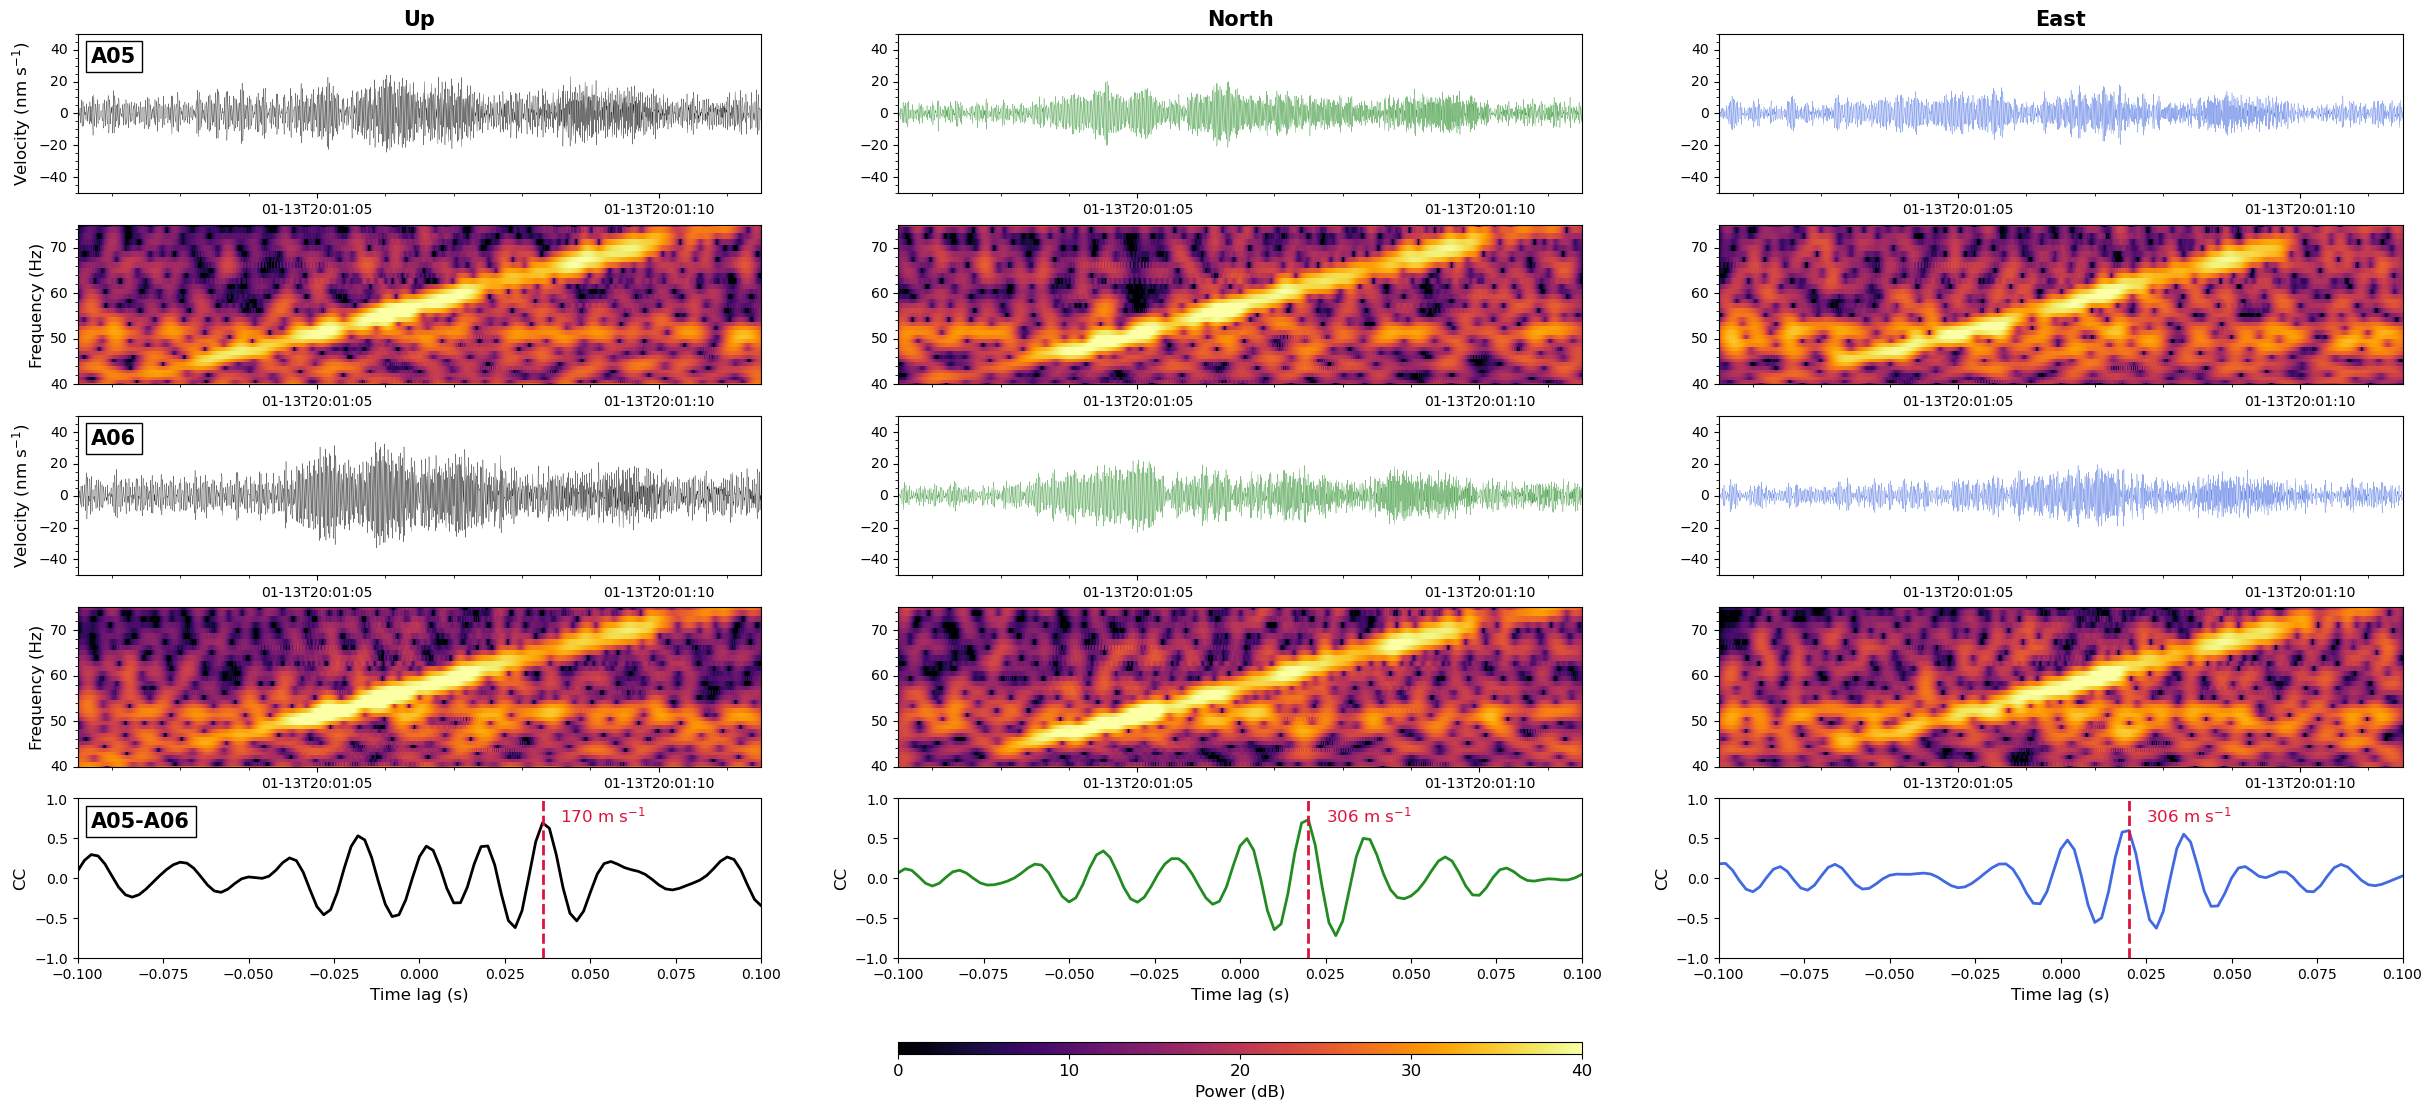

In [21]:
# Plotting
## Base plot
fig, axes = plot_waveforms_cwt_and_xcorr(stream, specs, cc_dict, (station1, station2), 
                                         wf_lim=wf_lim, freq_lim=freq_lim, dbmin=dbmin, dbmax=dbmax, linewidth_wf=linewidth_wf, linewidth_cc=linewidth_cc,
                                         major_time_spacing=duration / 2.0, minor_time_spacing=duration / 10.0)

## Plot the max CC times
for i, component in enumerate(components):
    time_max = time_max_dict[(station1, station2, component)]
    vel_app = dist / time_max
    ax = axes[4, i]
    
    ax.axvline(x=time_max, color="crimson", linestyle="--", linewidth=linewdith_max)
    ax.text(time_max + 0.005, 0.8, f"{vel_app:.0f} m s$^{{-1}}$", color="crimson", fontsize=12, ha="left", va="center")


In [22]:
# Save the figure
timestr = time2filename(starttime)
figname = f"high_q_glider_waveforms_and_cc_{timestr}_{station1}_{station2}.png"

save_figure(fig, figname, outdir=rootdir)

Figure saved to /Volumes/OmanData/data/geophones/high_q_glider_waveforms_and_cc_20200113T200101_A05_A06.png
